In [253]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from scipy.io import wavfile
import scipy.signal as signal
import matplotlib.pyplot as plt
import os
import pickle as pk
import scipy.sparse.linalg as la

# Training Data PCA and Labels

In [254]:
def pca_training_data(dims = 20):
    """
    Performs PCA on the training data saved in the subset train data .npy file.
    train_data is a 2D array of shape (num_features, num_samples).

    Args:
        dims: The number of dimensions to reduce to.

    Returns:
        pca: The PCA object used to perform the transformation.
        Z: The transformed data.
    """
    train_data = np.load('subset_train_data3.npy')
    train_data = np.abs(train_data).T
    pca = PCA(n_components = dims)
    pca.fit(train_data)
    Z = pca.transform(train_data)
    return pca, Z.T

In [255]:
def create_training_data_labels(noise_files = 1):
    """
    Creates a labels array for the training data. The labels are 0 for noise and 1 for music.
    label_shapes is a 1D array of shape (num_samples,) containing the number of samples for each class.
    
    Args:
        noise_files: The number of noise files in the training data.
    
    Returns:
        labels: The labels array.
    """
    lable_shapes = np.load('subset_labels_shape3.npy')
    total = sum(lable_shapes)

    mid = 0
    for i in range(noise_files):
        mid += lable_shapes[i]
    
    labels = []
    for i in range(mid):
        labels.append(0)
    for i in range(mid, total):
        labels.append(1)
    labels = np.array(labels)

    return labels

In [256]:
pca, transformed_train_data = pca_training_data()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [257]:
train_labels = create_training_data_labels()

# Gaussian Classifier 

In [258]:
def multivar_gaussian_pdf(x: np.ndarray, mu: np.ndarray, sigma: np.ndarray) -> float:
    """
    Given the mean and covariance matrix of a multivariate normal distribution, compute the probability density of x.

    Args:
        x: the input point to compute the probability density of
        mu: the mean of the multivariate normal distribution
        sigma: the covariance matrix of the multivariate normal distribution
    
    Returns:
        The probability density of x

    Throws:
        ValueError: if the dimensions of mu and sigma do not match
        ValueError: if sigma is not positive definite
    """
    if mu.shape[0] != sigma.shape[0] or mu.shape[0] != sigma.shape[1]:
        raise ValueError("Dimensions of mu and sigma do not match")
    if mu.shape[0] != x.shape[0]:
        raise ValueError("Dimensions of mu and x do not match")
    if not np.all(np.linalg.eigvals(sigma) > 0):
        print("Sigma is not positive definite... Using diagonal")
        sigma = np.diag(np.diag(sigma))

    d = x.shape[0]
    # handle case when multiple points given as columns in x
    if len(x.shape) > 1:
        mu = mu.reshape(-1, 1)
        return 1 / (np.sqrt((2*np.pi)**d * np.linalg.det(sigma)) + 1e-5) * np.exp(-0.5 * np.diag((x - mu).T @ np.linalg.inv(sigma) @ (x - mu)))
    
    return 1 / (np.sqrt((2*np.pi)**d * np.linalg.det(sigma)) + 1e-5) * np.exp(-0.5 * (x - mu).T @ np.linalg.inv(sigma) @ (x - mu))
    

In [259]:
def fit_gaussian(D: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
    """
    Given a set of data points D (d x n), fit a multivariate normal distribution to the data.

    Args:
        D: the data matrix. Each column is a data point.

    Returns:
        Mean and covariance matrix of the fitted distribution in a tuple.
    """
    mu = np.mean(D, axis=1)
    sigma = np.cov(D).reshape(mu.shape[0], mu.shape[0])
    return mu, sigma

In [260]:
class GaussianClassifier():
    """
    Gaussian classifier for n classes. Fits a multivariate normal distribution to each class in training data
    and classifies new data points based on the posterior probability density of the point under each distribution
    using the Baye's decision rule.
    """

    def __init__(self, nclass) -> None:
        self.nclass = nclass     # list of possible labels to classify as
        self.class_models = []   # gaussian model fit to each class
    
    def fit(self, train_data: np.ndarray, train_labels: np.ndarray) -> None:
        """
        Fit a gaussian model to each class in the training data.

        Args:
            train_data: d x n matrix of training data. Each column is a data point.
            train_labels: 1 x n vector of labels for each data point in train_data.
                          Assumes all elements of train_labels are one of 0..(nclass-1)
        """
        self.class_models = [fit_gaussian(train_data[:, train_labels == i]) for i in range(self.nclass)]

    def predict_proba(self, x: np.ndarray) -> np.ndarray:
        """
        Return p(x | class) for each class in the model
        """
        return np.array([multivar_gaussian_pdf(x, mu, sigma) for mu, sigma in self.class_models])

    def predict(self, x: np.ndarray) -> int:
        return np.argmax(self.predict_proba(x), axis=0)
    
    def evaluate(self, data: np.ndarray, labels: np.ndarray) -> float:
        """
        Evaluate the accuracy of the classifier on the given dataset.
        Compare what the model classifies each data point as to what the actual label is.
        """
        acc = np.mean(self.predict(data) == labels)
        return acc

In [261]:
def train_gaussian_classifier(transformed_train_data: np.ndarray, train_labels: np.ndarray):
    """
    Train a gaussian classifier on the training data.

    Args:
        transformed_train_data: (num_features, num_samples) array of training data transformed by PCA.
        train_labels: (num_samples,) array of labels for each data point in transformed_train_data.

    Returns:
        features: The PCA object that transforms the training data. Will be used to transform the test data.
        classifier: The trained gaussian classifier.
    """

    classifier = GaussianClassifier(2)
    classifier.fit(transformed_train_data, train_labels)
    
    return classifier

In [262]:
gaussian_classifier = train_gaussian_classifier(transformed_train_data, train_labels)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


# KNN Classifier

In [263]:
def train_KNN_classifier(transformed_train_data: np.ndarray, train_labels: np.ndarray):
    """
    Train a KNN classifier on the training data.

    Args:
        transformed_train_data: (num_features, num_samples) array of training data transformed by PCA.
        train_labels: (num_samples,) array of labels for each data point in transformed_train_data.

    Returns:
        features: The PCA object that transforms the training data. Will be used to transform the test data.
        classifier: The trained KNN classifier.
    """

    train = transformed_train_data.T

    # KNN classifier takes in a 2D array of shape (num_samples, num_features) so we transpose the data
    classifier = KNeighborsClassifier(n_neighbors = 2, metric = 'manhattan')
    classifier.fit(train, train_labels)

    return classifier

In [264]:
knn_classifier = train_KNN_classifier(transformed_train_data, train_labels)

# Input Audio File Classification

In [265]:
def display_spectrogram(spec: np.ndarray, rate: float, audiolen: int, title: str = None):
    plt.figure(figsize=(20, 5))
    plt.imshow(np.sqrt(np.abs(spec)),
           cmap='turbo', origin='lower', aspect='auto',
           extent=[0, audiolen/rate, 0, rate/2])
    plt.xlabel('Time [s]')
    plt.ylabel('Frequency [Hz]')
    if title is not None:
        plt.title(title)
    plt.show()

In [266]:
def classify_audio(file = "./love_of_my_life.wav"):
    """
    Classifies the audio file as either speech or noise.

    Args:
        file: The path to the audio file to classify.

    Returns:
        The classification of the audio file.
    """

    rate, audio = wavfile.read(file)
    audio = np.mean(audio, axis=1, keepdims=True).squeeze()
    audio = np.array(audio, dtype = float)
    frequencies, times, spectrogram = signal.stft(audio, rate)
    display_spectrogram(spectrogram, rate, len(audio), title = 'Ground Truth')
    plt.show()
    
    transformed_spectrogram = pca.transform(np.abs(spectrogram).T).T

    # The KNN classifier predict function takes in a 2D array of shape (num_samples, num_features) so we transpose the data
    preds = gaussian_classifier.predict(transformed_spectrogram)

    return spectrogram, preds

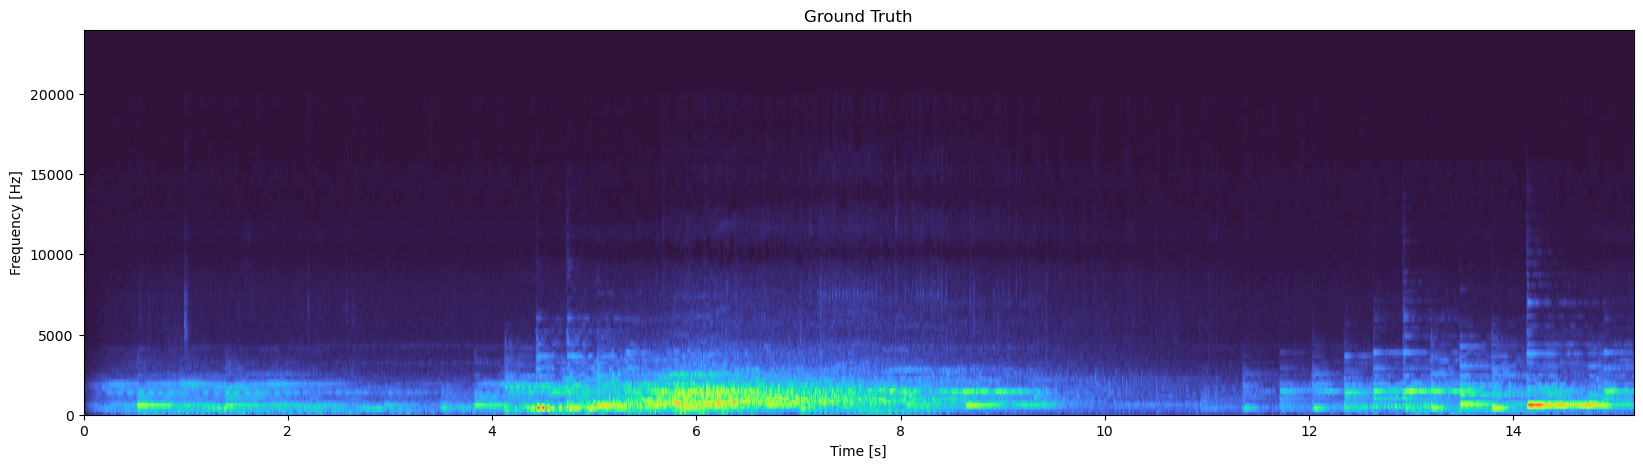

In [267]:
spectrogram, preds = classify_audio()

# Low Energy Frames Removal

In [268]:
def low_energy_frames():
    plt.figure(figsize=(16, 5))
    plt.title("Energy of the Spectogram")
    plt.xlabel("Spectogram Columns")
    plt.ylabel("Energy")
    energy = []
    temp_spectrogram = np.abs(spectrogram)
    for frame in temp_spectrogram.T:
        e = np.sum(frame ** 2)
        energy.append(e)
    plt.plot(energy)
    # mean_energy = np.mean(energy)
    # std_energy = np.std(energy)
    threshold = np.percentile(energy, 25)
    plt.plot([0, len(energy)], [threshold, threshold], color = 'red')
    idxs = np.where(energy < threshold)
    return idxs[0]

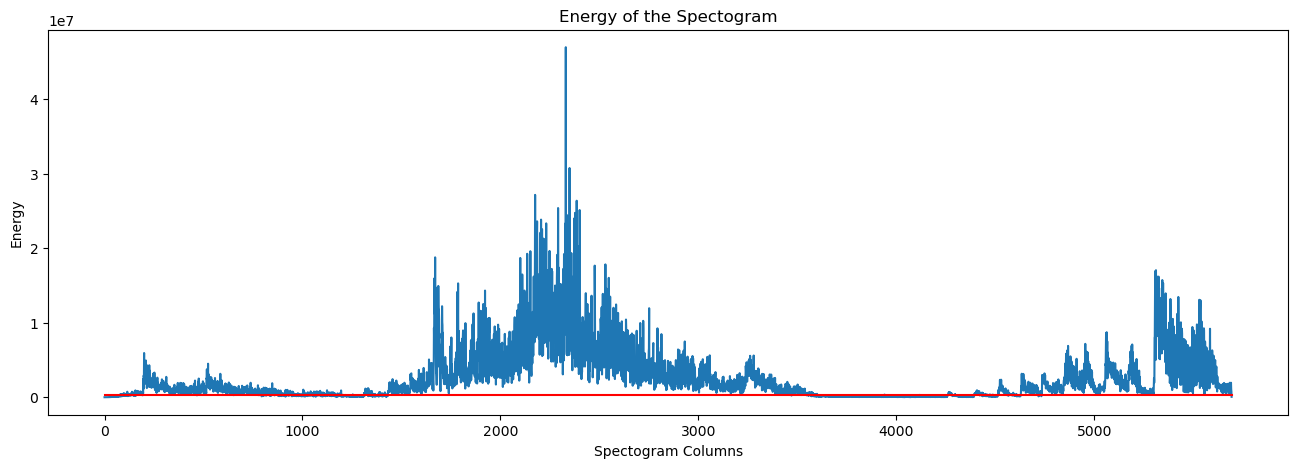

In [269]:
frames = low_energy_frames()

# Visualize Classification Results

In [270]:
def visualize_audio_pred(preds: np.ndarray, window_size = 25):
    """
    Visualizes the classification of the audio file.
    Applies a window of size window_size to the predictions and takes the majority vote of the window to classify the spectrogram.
    Window ensures minimal contextual information is taken into account when classifying the spectrogram.

    Args:
        preds: (num_samples,) array of labels for each data point in the audio file.
        window: The size of the window to apply to the predictions.
    """

    plt.figure(figsize=(20, 3))
    plt.title("Classification of Feature Vectors of the Spectogram (columns of the plot) into 2 Clusters (rows of the plot)")
    plt.xlabel("Spectogram Columns")
    plt.ylabel("Clusters: 0, 1")

    window_preds = [1 for _ in range(25)]
    for i in range(window_size, len(preds)):
        window = preds[i - window_size : i + window_size]
        window_preds.append(np.argmax(np.bincount(window)))

    for idx, point in enumerate(window_preds):
        if idx not in frames:
            if point == 0:
                plt.plot(idx, point, 'o', color = 'red', markersize = 1)
            elif point == 1:
                plt.plot(idx, point, 'o', color = 'blue', markersize = 1)
    plt.show()

    return window_preds

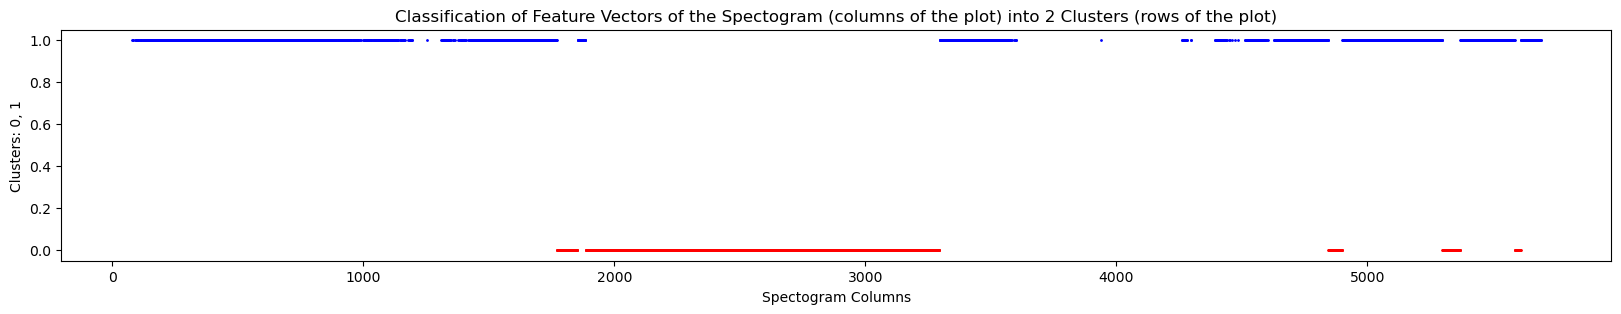

In [271]:
window_preds = visualize_audio_pred(preds)

# Removal of Noise Frames from Spectrogram

In [272]:
def remove_noise_from_spectrogram(preds, file = "./love_of_my_life.wav"):
    """
    Removes the noise from the spectrogram.

    Args:
        preds: (num_samples,) array of labels for each data point in the audio file.

    Returns:
        The spectrogram with the noise removed.
    """

    rate, audio = wavfile.read(file)
    audio = np.array(audio, dtype = float)
    audio = np.mean(audio, axis=1, keepdims=True).squeeze()
    frequencies, times, spectrogram = signal.stft(audio, rate)

    clean_spectrogram = spectrogram * preds

    display_spectrogram(clean_spectrogram, rate, len(audio), title = 'Clean Spectrogram')

    return rate, len(audio), clean_spectrogram

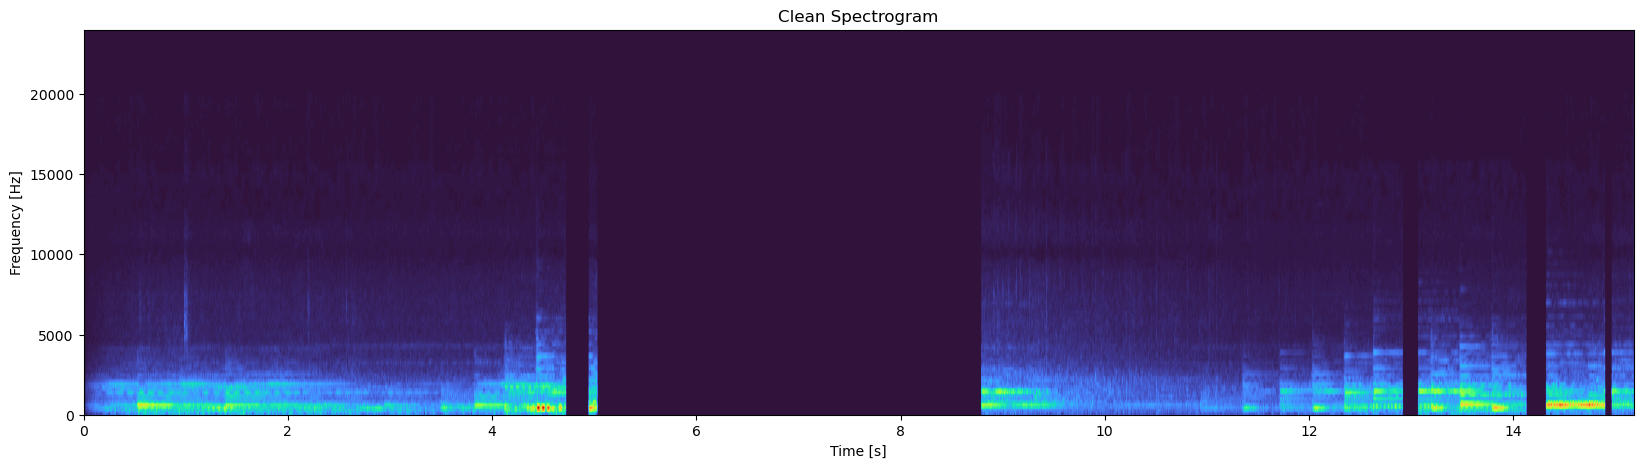

In [273]:
rate, audiolen, clean_spectrogram = remove_noise_from_spectrogram(window_preds)

# Unsupervised Classification Models

In [274]:
from sklearn.mixture import GaussianMixture

In [275]:
def gaussian_mixture_model(file = "./love_of_my_life.wav"):
    rate, audio = wavfile.read(file)
    audio = np.mean(audio, axis=1, keepdims=True).squeeze()
    audio = np.array(audio, dtype = float)
    frequencies, times, spectrogram = signal.stft(audio, rate)
    display_spectrogram(spectrogram, rate, len(audio), title = 'Ground Truth')
    
    data = np.abs(spectrogram).T
    gmm = GaussianMixture(n_components = 2).fit(data)
    preds = gmm.predict(data)

    return preds

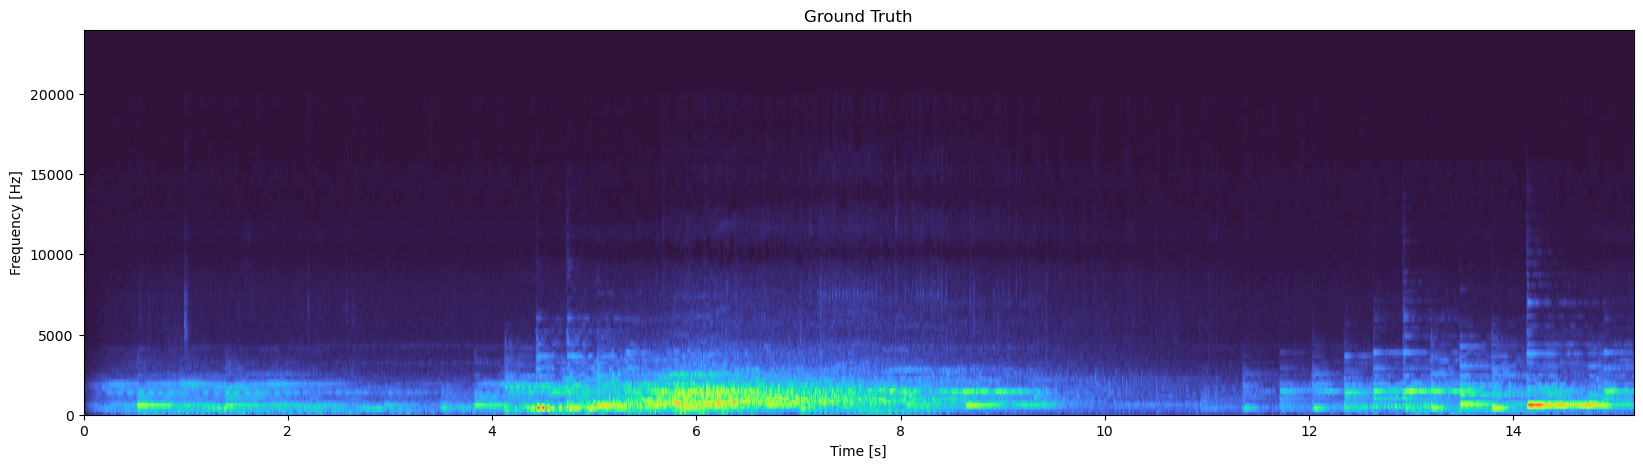

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [276]:
preds = gaussian_mixture_model()

In [277]:
def visualize_unsupervised_audio_pred(preds: np.ndarray, window_size = 5):
    """
    Visualizes the classification of the audio file based on the unsupervised learning model.
    Applies a window of size window_size to the predictions and takes the majority vote of the window to classify the spectrogram.
    Window ensures minimal contextual information is taken into account when classifying the spectrogram.

    Args:
        preds: (num_samples,) array of labels for each data point in the audio file.
        window: The size of the window to apply to the predictions.
    """

    plt.figure(figsize=(20, 3))
    plt.title("Classification of Feature Vectors of the Spectogram (columns of the plot) into 2 Clusters (rows of the plot)")
    plt.xlabel("Spectogram Columns")
    plt.ylabel("Clusters: 0, 1")

    window_preds = []
    for i in range(window_size, len(preds)):
        window = preds[i - window_size : i + window_size]
        window_preds.append(np.argmax(np.bincount(window)))

    for idx, point in enumerate(window_preds):
        if point == 0:
            plt.plot(idx, point, 'o', color = 'red', markersize = 1)
        else:
            plt.plot(idx, point, 'o', color = 'blue', markersize = 1)    
    plt.show()

    return window_preds

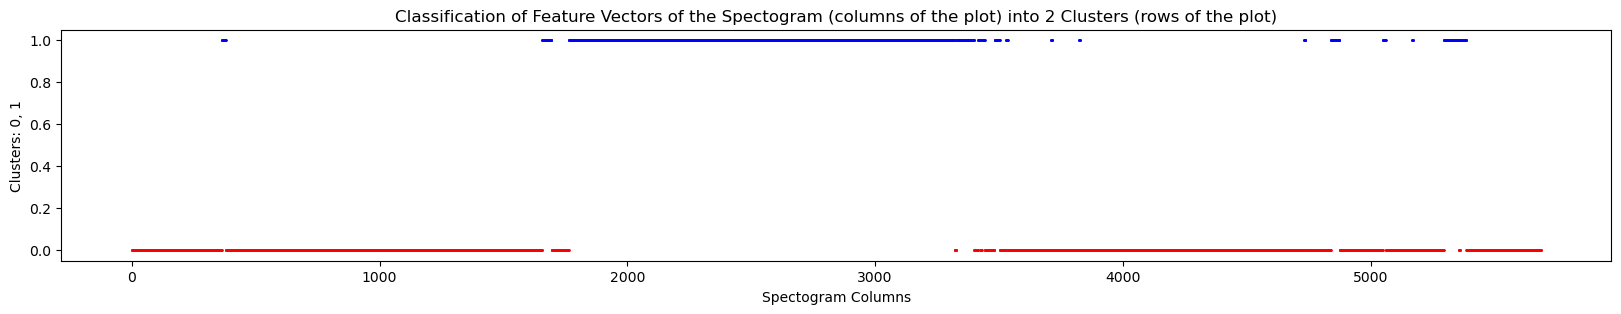

In [278]:
window_preds = visualize_unsupervised_audio_pred(preds)

# Simple Imputation Methods

In [295]:
def em_svd(spectrogram: np.ndarray, rank = 10, maxiter = 10) -> np.ndarray:
    """
    Approximate SVD on data with missing values via expectation-maximization

    Arguments:
        spectrogram: (num_observations, num_dimensions) data matrix, missing values denoted by np.nan

    Returns:
        imputed_spectrogram: (num_observations, num_dimensions) reconstructed data matrix
    """

    spectrogram = np.where(spectrogram==0, np.nan, spectrogram)

    mu_hat = np.nanmean(spectrogram, axis=1, keepdims=1)
    valid = np.isfinite(spectrogram)
    imputed_spectrogram = np.where(valid, spectrogram, mu_hat)

    run = True
    iter = 1
    v_prev = 0

    while run:

        # SVD on filled-in data
        U, s, Vt = la.svds(imputed_spectrogram - mu_hat, rank)

        # impute missing values
        imputed_spectrogram[~valid] = (U.dot(np.diag(s)).dot(Vt) + mu_hat)[~valid]

        # update bias parameter
        mu_hat = imputed_spectrogram.mean(axis=0, keepdims=1)

        # test convergence using relative change in trace norm
        v = s.sum()
        if iter >= maxiter or ((v - v_prev) / (v_prev + 1e-6)) < 1e-6:
            run = False
        iter += 1
        v_prev = v
    
    return imputed_spectrogram

In [296]:
clean_spectrogram.shape

(129, 5694)

In [297]:
imputed_spectrogram = em_svd(np.abs(clean_spectrogram))

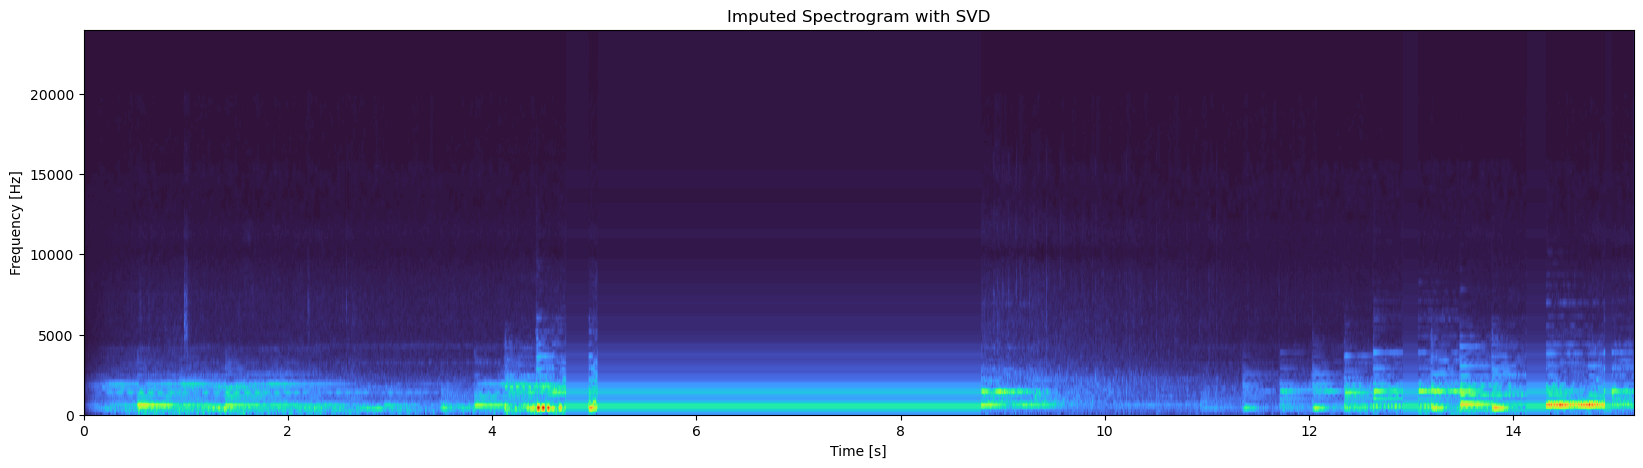

In [299]:
display_spectrogram(imputed_spectrogram, rate, audiolen, title = 'Imputed Spectrogram with SVD')